In [1]:
import numpy as np
import netCDF4 as nc4
import datetime as dt
import matplotlib.pyplot as plt
import math
import glob
import math
import sim_name_remap as map
import pickle as pkl

In [2]:

def get_model_TOA_RF(MODEL_ROOT, years, RF_choice): 

    print(RF_choice) 
    
    model_TOA_RF = []
    model_year_plot = []
    
    for year in years:    
        model_year_plot.append(year+0.5)
        MODEL_FILES = glob.glob(MODEL_ROOT + str(int(year)) + '*')
    
        curr_TOA_RFs = []  # All the TOA_RFs for the current year
    
        for file in MODEL_FILES:
            
            nc = nc4.Dataset(file)
            if RF_choice == 'LW':  curr_TOA_RF = nc.variables['FLNT'][:]
            if RF_choice == 'SW':  curr_TOA_RF = nc.variables['FSNT'][:]  
            if RF_choice == 'SWC':  curr_TOA_RF = nc.variables['FSNTC'][:]  
            if RF_choice == 'LWC':  curr_TOA_RF = nc.variables['FLNTC'][:]  
            if RF_choice == 'SW-LW': curr_TOA_RF = nc.variables['FSNT'][:]-nc.variables['FLNT'][:]
            if RF_choice == 'AOD': curr_TOA_RF = nc.variables['AODVISstdn'][:]
            if RF_choice == 'SW_Aer': curr_TOA_RF = nc.variables['FSNT'][:]-nc.variables['FSNT_d1'][:]
            if RF_choice == 'LW_Aer': curr_TOA_RF = nc.variables['FLNT'][:]-nc.variables['FLNT_d1'][:]
            if RF_choice == 'SW_Cld': curr_TOA_RF = nc.variables['FSNT'][:]-nc.variables['FSNTC'][:]
            if RF_choice == 'LW_Cld': curr_TOA_RF = nc.variables['FLNT'][:]-nc.variables['FLNTC'][:]
            
            if RF_choice == 'SW_CF': curr_TOA_RF = nc.variables['SWCF'][:]
            
            curr_TOA_RFs.append(np.mean(curr_TOA_RF))
    
        model_TOA_RF.append(np.mean(curr_TOA_RFs))
        
    return np.asarray(model_TOA_RF), model_year_plot


In [3]:

def get_TOA_timeseries(CAMSsim, MEICsim, SAVEDIR):

    SAVEFILE = SAVEDIR + 'TOA_RF_vars_' + CAMSsim + '_' + MEICsim + '.pkl'

    if os.path.isfile(SAVEFILE):
        print('File exists, reading it...')

        with open(SAVEFILE,'rb') as f:
            year_plot, TOA_Aer_SWRF_Diff, TOA_Tot_SWRF_Diff, TOA_Clr_SWRF_Diff, TOA_Aer_LWRF_Diff, TOA_Tot_LWRF_Diff, TOA_Clr_LWRF_Diff, TOA_Aer_NetRF_Diff, TOA_Tot_NetRF_Diff, TOA_Clr_NetRF_Diff = pkl.load(f)

    else: 

        print('File not found, calculating fields...')
        
        # Read the model information
        years = np.arange(2010,2020.1)
        
        CAMSROOT = map.remap[CAMSsim]
        MEICROOT = map.remap[MEICsim]
        
        CAMS_TOA_Aer_SWRF, year_plot = get_model_TOA_RF(CAMSROOT, years, 'SW_Aer')
        #CAMS_TOA_Cld_SWRF, year_plot = get_model_TOA_RF(CAMSROOT, years, 'SW_Cld')
        CAMS_TOA_Tot_SWRF, year_plot = get_model_TOA_RF(CAMSROOT, years, 'SW')
        CAMS_TOA_SWC_SWRF, year_plot = get_model_TOA_RF(CAMSROOT, years, 'SWC')
        
        MEIC_TOA_Aer_SWRF, year_plot = get_model_TOA_RF(MEICROOT, years, 'SW_Aer')
        #MEIC_TOA_Cld_SWRF, year_plot = get_model_TOA_RF(MEICROOT, years, 'SW_Cld')
        MEIC_TOA_Tot_SWRF, year_plot = get_model_TOA_RF(MEICROOT, years, 'SW')
        MEIC_TOA_SWC_SWRF, year_plot = get_model_TOA_RF(MEICROOT, years, 'SWC')
        
        CAMS_TOA_Aer_LWRF, year_plot = get_model_TOA_RF(CAMSROOT, years, 'LW_Aer')
        #CAMS_TOA_Cld_LWRF, year_plot = get_model_TOA_RF(CAMSROOT, years, 'LW_Cld')
        CAMS_TOA_Tot_LWRF, year_plot = get_model_TOA_RF(CAMSROOT, years, 'LW')
        CAMS_TOA_LWC_LWRF, year_plot = get_model_TOA_RF(CAMSROOT, years, 'LWC')
        
        MEIC_TOA_Aer_LWRF, year_plot = get_model_TOA_RF(MEICROOT, years, 'LW_Aer')
        #MEIC_TOA_Cld_LWRF, year_plot = get_model_TOA_RF(MEICROOT, years, 'LW_Cld')
        MEIC_TOA_Tot_LWRF, year_plot = get_model_TOA_RF(MEICROOT, years, 'LW')
        MEIC_TOA_LWC_LWRF, year_plot = get_model_TOA_RF(MEICROOT, years, 'LWC')

        ######## MEIC minus CAMS!!!
        
        TOA_Aer_SWRF_Diff = MEIC_TOA_Aer_SWRF-CAMS_TOA_Aer_SWRF
        #TOA_Cld_SWRF_Diff = MEIC_TOA_Cld_SWRF-CAMS_TOA_Cld_SWRF
        TOA_Tot_SWRF_Diff = MEIC_TOA_Tot_SWRF-CAMS_TOA_Tot_SWRF
        TOA_Clr_SWRF_Diff = MEIC_TOA_SWC_SWRF-CAMS_TOA_SWC_SWRF
        
        TOA_Aer_LWRF_Diff = MEIC_TOA_Aer_LWRF-CAMS_TOA_Aer_LWRF
        #TOA_Cld_LWRF_Diff = MEIC_TOA_Cld_LWRF-CAMS_TOA_Cld_LWRF
        TOA_Tot_LWRF_Diff = MEIC_TOA_Tot_LWRF-CAMS_TOA_Tot_LWRF
        TOA_Clr_LWRF_Diff = MEIC_TOA_LWC_LWRF-CAMS_TOA_LWC_LWRF
        
        TOA_Aer_NetRF_Diff = TOA_Aer_SWRF_Diff - TOA_Aer_LWRF_Diff  # Net = SW minus LW
        #TOA_Cld_NetRF_Diff = TOA_Cld_SWRF_Diff - TOA_Cld_LWRF_Diff  # Net = SW minus LW
        TOA_Tot_NetRF_Diff = TOA_Tot_SWRF_Diff - TOA_Tot_LWRF_Diff  # Net = SW minus LW
        TOA_Clr_NetRF_Diff = TOA_Clr_SWRF_Diff - TOA_Clr_LWRF_Diff  # Net = SW minus LW

        with open(SAVEFILE, 'wb') as f: 
            pkl.dump((year_plot, TOA_Aer_SWRF_Diff, TOA_Tot_SWRF_Diff, TOA_Clr_SWRF_Diff, TOA_Aer_LWRF_Diff, TOA_Tot_LWRF_Diff, TOA_Clr_LWRF_Diff, TOA_Aer_NetRF_Diff, TOA_Tot_NetRF_Diff, TOA_Clr_NetRF_Diff),f)

    return year_plot, TOA_Aer_SWRF_Diff, TOA_Tot_SWRF_Diff, TOA_Clr_SWRF_Diff, TOA_Aer_LWRF_Diff, TOA_Tot_LWRF_Diff, TOA_Clr_LWRF_Diff, TOA_Aer_NetRF_Diff, TOA_Tot_NetRF_Diff, TOA_Clr_NetRF_Diff
    

In [4]:

SAVEDIR = '/glade/derecho/scratch/wsmith/carma_vars/'

year_plot, TOA_Aer_SWRF_Diff_CARMA, TOA_Tot_SWRF_Diff_CARMA, TOA_Clr_SWRF_Diff_CARMA, TOA_Aer_LWRF_Diff_CARMA, TOA_Tot_LWRF_Diff_CARMA, TOA_Clr_LWRF_Diff_CARMA, TOA_Aer_NetRF_Diff_CARMA, TOA_Tot_NetRF_Diff_CARMA, TOA_Clr_NetRF_Diff_CARMA\
    = get_TOA_timeseries('CARMA_CAMS_SO2_rad', 'CARMA_MEIC_SO2_rad', SAVEDIR)
year_plot, TOA_Aer_SWRF_Diff_MAM4, TOA_Tot_SWRF_Diff_MAM4, TOA_Clr_SWRF_Diff_MAM4, TOA_Aer_LWRF_Diff_MAM4, TOA_Tot_LWRF_Diff_MAM4, TOA_Clr_LWRF_Diff_MAM4, TOA_Aer_NetRF_Diff_MAM4, TOA_Tot_NetRF_Diff_MAM4, TOA_Clr_NetRF_Diff_MAM4\
    = get_TOA_timeseries('MAM4_CAMS6.2_SO2_rad', 'MAM4_MEIC_SO2_rad', SAVEDIR)


File exists, reading it...
File exists, reading it...


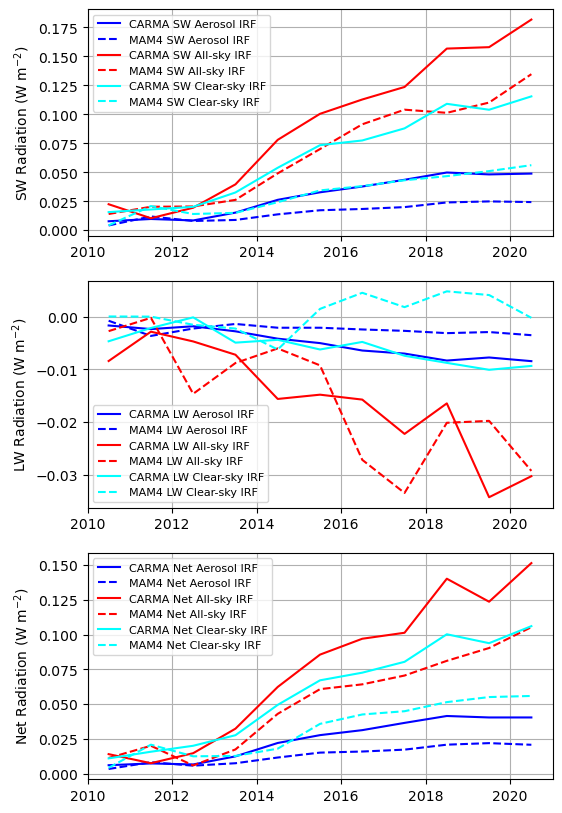

In [5]:

# Plot
fig = plt.figure(figsize=(6,10))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
#if RF_choice != 'AOD': plt.plot(year_plot[:-2], TOA_RF_anom_annual[:-2], linewidth=2, color='k')  # Note the manual screen here to drop out 2022-23

ax1.plot(year_plot, TOA_Aer_SWRF_Diff_CARMA, color='blue', label= 'CARMA SW Aerosol IRF')
ax1.plot(year_plot, TOA_Aer_SWRF_Diff_MAM4, color='blue', label= 'MAM4 SW Aerosol IRF', linestyle='--')

ax1.plot(year_plot, TOA_Tot_SWRF_Diff_CARMA, color='red', label= 'CARMA SW All-sky IRF')
ax1.plot(year_plot, TOA_Tot_SWRF_Diff_MAM4, color='red', label= 'MAM4 SW All-sky IRF', linestyle='--')

ax1.plot(year_plot, TOA_Clr_SWRF_Diff_CARMA, color='cyan', label = 'CARMA SW Clear-sky IRF')
ax1.plot(year_plot, TOA_Clr_SWRF_Diff_MAM4, color='cyan', label = 'MAM4 SW Clear-sky IRF', linestyle='--')

#ax1.plot(year_plot, TOA_Cld_SWRF_Diff, color='orange', label= 'SW Cloud RF (MEIC minus CAMS)')

ax2.plot(year_plot, -TOA_Aer_LWRF_Diff_CARMA, color='blue', label= 'CARMA LW Aerosol IRF')
ax2.plot(year_plot, -TOA_Aer_LWRF_Diff_MAM4, color='blue', label= 'MAM4 LW Aerosol IRF', linestyle='--')

ax2.plot(year_plot, -TOA_Tot_LWRF_Diff_CARMA, color='red', label= 'CARMA LW All-sky IRF')
ax2.plot(year_plot, -TOA_Tot_LWRF_Diff_MAM4, color='red', label= 'MAM4 LW All-sky IRF', linestyle='--')

ax2.plot(year_plot, -TOA_Clr_LWRF_Diff_CARMA, color='cyan', label = 'CARMA LW Clear-sky IRF')
ax2.plot(year_plot, -TOA_Clr_LWRF_Diff_MAM4, color='cyan', label = 'MAM4 LW Clear-sky IRF', linestyle='--')

#ax2.plot(year_plot, TOA_Cld_LWRF_Diff, color='orange', label= 'LW Cloud RF (MEIC minus CAMS)')

ax3.plot(year_plot, TOA_Aer_NetRF_Diff_CARMA, color='blue', label= 'CARMA Net Aerosol IRF')
ax3.plot(year_plot, TOA_Aer_NetRF_Diff_MAM4, color='blue', label= 'MAM4 Net Aerosol IRF', linestyle='--')

ax3.plot(year_plot, TOA_Tot_NetRF_Diff_CARMA, color='red', label= 'CARMA Net All-sky IRF')
ax3.plot(year_plot, TOA_Tot_NetRF_Diff_MAM4, color='red', label= 'MAM4 Net All-sky IRF', linestyle='--')

ax3.plot(year_plot, TOA_Clr_NetRF_Diff_CARMA, color='cyan', label='CARMA Net Clear-sky IRF')
ax3.plot(year_plot, TOA_Clr_NetRF_Diff_MAM4, color='cyan', label='MAM4 Net Clear-sky IRF', linestyle='--')

#ax3.plot(year_plot, TOA_Cld_NetRF_Diff, color='orange', label= 'Net (SW minus LW) Cloud RF (MEIC minus CAMS)')

ax1.legend(fontsize=8)
ax2.legend(fontsize=8)
ax3.legend(fontsize=8)

#plt.plot(model_year_plot, MEIC_TOA_RF, color='orange')
#if RF_choice == 'AOD': plt.ylabel('AOD')
#else: plt.ylabel(RF_choice + ' Net Radiation (W m$^{-2}$)') 
ax1.set_ylabel('SW Radiation (W m$^{-2}$)')
ax2.set_ylabel('LW Radiation (W m$^{-2}$)')
ax3.set_ylabel('Net Radiation (W m$^{-2}$)')

ax1.grid()
ax2.grid()
ax3.grid()

plt.savefig('/glade/u/home/wsmith/ASM_SO4_scripts/plots/Figure3.png')
plt.savefig('/glade/u/home/wsmith/ASM_SO4_scripts/plots/Figure3.pdf')



In [6]:
#plt.plot(model_year_plot, np.asarray(MEIC_TOA_RF)-np.asarray(CAMS_TOA_RF), color='purple')